# Приоритезация гипотез и анализ результатов А/В теста

**Бизнес-задача**
- Оценить  наиболее ценные гипотезы с точки зрения профита для бизнеса.
- Проанализировать результаты тестировани, чтобы принять обоснованное решение о возможных измменениях

**Ход исследования:**

1. Приоритизировать гипотезы
2. Загрузить датасеты с результатами проведенного A/B-теста, оценить валидность предоставленных данных
3. Подготовить сводный датафрейм с метриками, необходимыми для исследования
4. Оценить кумулятивные  показатели тестируемых групп:
- кумулятивная выручка по группам
- кумулятивный средний чек по группам
- кумулятивное средние количество заказов на посетителя по группам
5. Оценить относительное изменение кумулятивного среднего чека и кумулятивного среднего количества заказов.
6. Оценить наличие выбросов в данных.
7.  Проверить гипотезы о равенстве средних чеков и количестве заказов на одного пользователя на сырых и очищенных данных.
8. Сформировать вывод и рекомендации для бизнеса.

In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import scipy.stats as st
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import norm
import datetime as dt
import scipy.stats as stats
from sqlalchemy import create_engine

# по умолчанию отображать 2 знака после запятой
pd.options.display.float_format = '{:.2f}'.format 

# по умолчанию отображать до 50 колонок
pd.options.display.max_columns = 50  

# увеличиваем максимальную ширину столбца, чтобы видеть больше данных
pd.set_option('display.max_colwidth', 130) 

# Отключаем уведомления о том, что в будущих версиях библиотеки будут отключены
# warnings.filterwarnings('ignore', category=FutureWarning) 

import warnings
warnings.filterwarnings("ignore")

## Приритезация гипотез

In [2]:
# прочитаем файл 
pth1 = 'hypothesis.csv'
pth2 = '/datasets/hypothesis.csv'


if os.path.exists(pth1):
    try: 
        hyp = pd.read_csv(pth1)
        print(f'Файл {pth1} успешно загружен')
    except:
        pass
elif os.path.exists(pth2):
    try: 
        hyp = pd.read_csv(pth2)
        print(f'Файл {pth2} успешно загружен')
    except:
        pass
else:
    print('Что-то пошло не так. Проверьте код')

Файл /datasets/hypothesis.csv успешно загружен


In [3]:
hyp

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Рассчитаем ICE для каждой гипотезы**

In [4]:
hyp['ICE']= hyp['Impact']* hyp['Confidence'] / hyp['Efforts']
hyp.sort_values('ICE', ascending= False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [5]:
hyp['RICE']= hyp['Reach']*hyp['Impact']* hyp['Confidence'] / hyp['Efforts']
hyp=hyp.sort_values('RICE', ascending= False)
hyp_styled2 = hyp.style.background_gradient(subset=['ICE','RICE'], cmap="coolwarm")
hyp_styled2

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


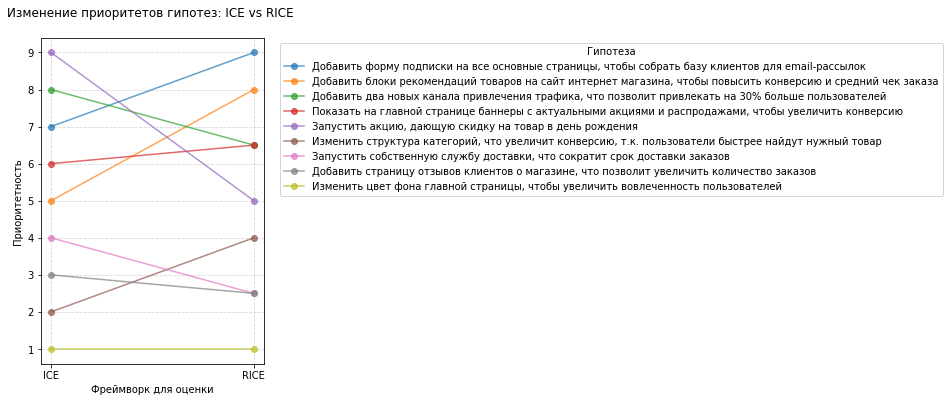

In [6]:
# Ранжирование гипотез по метрикам
hyp["Rank_ICE"] = hyp["ICE"].rank()#ascending=False)
hyp["Rank_RICE"] = hyp["RICE"].rank()#ascending=False)

# Подготовка данных для графика
df_melted = hyp.melt(id_vars=["Hypothesis"], value_vars=["Rank_ICE", "Rank_RICE"], 
                     var_name="Stage", value_name="Rank")
df_melted["Stage"] = df_melted["Stage"].map({"Rank_ICE": "ICE", "Rank_RICE": "RICE"})

# Визуализация Slope Graph
fig, ax = plt.subplots(figsize=(4, 6))

# Построение линий для каждой гипотезы
for hyp_name in hyp["Hypothesis"]:
    data = df_melted[df_melted["Hypothesis"] == hyp_name]
    ax.plot(data["Stage"], data["Rank"], marker="o", label=hyp_name, alpha=0.7)

# Настройки графика
ax.set_title("Изменение приоритетов гипотез: ICE vs RICE \n")
ax.set_xlabel("Фреймворк для оценки")
ax.set_ylabel("Приоритетность")
ax.set_xticks(["ICE", "RICE"])
ax.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Гипотеза", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

plt.show()

### Итог:

После анализа в фрейворке ICE наиболее перспективными являются гипотезы: 
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Однако после добавления в качестве критерия приоритезирования количества клиентов, на которых повлияет изменение, на первые места по совокупности факторов выходят:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей/

Рекомендуем в первую очередь брать в проработку топ гипотез, оцененных по методике RICE, т.к. они затрагивают большее количество пользователей, а значит потенциально способны принести больший профит компании.
 

## Проанализируем результаты A/B теста

### Загрузим данные для анализа

In [7]:
# прочитаем файл 
pth1 = 'orders.csv'
pth2 = '/datasets/orders.csv'

if os.path.exists(pth1):
    try: 
        orders = pd.read_csv(pth1)
        print(f'Файл {pth1} успешно загружен')
    except:
        pass
elif os.path.exists(pth2):
    try: 
        orders = pd.read_csv(pth2)
        print(f'Файл {pth2} успешно загружен')
    except:
        pass
else:
    print('Что-то пошло не так. Проверьте код')

# прочитаем файл 
pth3 = 'visitors.csv'
pth4 = '/datasets/visitors.csv'


if os.path.exists(pth3):
    try: 
        visitors = pd.read_csv(pth3)
        print(f'Файл {pth3} успешно загружен')
    except:
        pass
elif os.path.exists(pth4):
    try: 
        visitors = pd.read_csv(pth4)
        print(f'Файл {pth4} успешно загружен')
    except:
        pass
else:
    print('Что-то пошло не так. Проверьте код')

Файл /datasets/orders.csv успешно загружен
Файл /datasets/visitors.csv успешно загружен


**orders**

In [8]:
orders.head(3)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
# приведем значения в столбце date к типу datetime
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'].dtype

dtype('<M8[ns]')

In [11]:
# определим границы теста
print(f"тест проводился с {orders['date'].min()} по {orders['date'].max()}")

тест проводился с 2019-08-01 00:00:00 по 2019-08-31 00:00:00


In [12]:
# проверим датафрейм на наличие дубликатов
orders.duplicated().sum()

0

In [13]:
# проверим корректность распределения пользователей по группам
q=orders.groupby('visitorId')['group'].nunique().sort_values().reset_index()
double = q.loc[q['group'] == 2]
len(double)

58

Мы видим, что 58 пользователей вошло в обе тестовые группы. Не ясны причины такой ситуации, так же не понятно насколько это "точечная проблема". Потенцально, такие данные могут говорить о неверно проведенном эксперименте и ставят под вопрос результаты всего тестирования.

В рамках данного исследования удалим из датасета пользователей, вошедших в обе тестовые группы. Однако при анализе результатов тестирования, стоит помнить, что проведенное А/В тестирование может оказаться полностью невалидным.

In [14]:
double_list = double['visitorId'].to_list()
# выведем количество записей для "дублирующихся" пользователей
len(orders.loc[ orders['visitorId'].isin(double_list)])

181

In [15]:
orders = orders.loc[~ orders['visitorId'].isin(double_list)]
len(orders)

1016

**visitors**

In [16]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [18]:
# проверимдатасет на наличие дубликатов
visitors.duplicated().sum()

0

In [19]:
# приведем значения в столбце date к типу datetime
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'].dtype

dtype('<M8[ns]')

In [20]:
# определим границы теста
print(f"тест проводился с {visitors['date'].min()} по {visitors['date'].max()}")

тест проводился с 2019-08-01 00:00:00 по 2019-08-31 00:00:00


In [21]:
# проанализируем сколько гипотез тестировалось в ходе эксперимента
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Тестировались только две гипотезы, поэтому нет необходимости корректировать уровень статистической значимости.

**Итог:**
1. Тест проводился с 2019-08-01 по 2019-08-31
2. Тестировались две гипотезы, т.е. нет необходимости корректировать уровень статистической значимости
3. Результаты A/B-теста будем анализировать на данных датасетов orders и visitors.
4. На этапе изучения данных обнаружена проблема:  58 пользователей вошло в обе тестовые группы. Не ясны причины такой ситуации, так же не понятно насколько это "точечная проблема". Потенцально, такие данные могут говорить о неверно проведенном эксперименте и ставят под вопрос результаты всего тестирования.
5. 
В рамках данного исследования удалим из датасета пользователей, вошедших в обе тестовые группы. Однако при анализе результатов тестирования, стоит помнить, что проведенное А/В тестирование может оказаться полностью невалидным.

### Подготовим данные для анализа

In [22]:
# выведем посетителей в группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']].sort_values('date')
visitorsADaily.columns = ['date', 'visitorsPerDateA']


# посчитаем накопительную сумму посетителей за каждый день
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head(3)

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845


In [23]:
# выведем посетителей в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']].sort_values('date')
visitorsBDaily.columns = ['date', 'visitorsPerDateB']


# посчитаем накопительную сумму посетителей за каждый день
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head(3)

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803


In [24]:
orders.head(3)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B


In [25]:
# выведем выручку по уникальным заказам в тестовой группе за каждый день
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily.head(3)

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473


In [26]:
# рассчитаемм кумулятивную выручку  в группе А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
ordersACummulative.head(3)

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854


In [27]:
# выведем выручку по уникальным заказам в тестовой группе B за каждый день
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily.head(3)

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049


In [28]:
# рассчитаемм кумулятивную выручку  в группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]
ordersBCummulative.head(3)

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850


Объединим полученные таблицы в один датафрейм

In [29]:
# приведем даты во всех датафреймах к datetime
dfs = [ordersADaily, ordersBDaily, ordersACummulative, ordersBCummulative, 
       visitorsADaily, visitorsBDaily, visitorsACummulative, visitorsBCummulative]
for df in dfs:
    df['date'] = pd.to_datetime(df['date'])

df = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

df.head(2)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294


**Итог:**
Создан сводный датафрейм со следуующими данными:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B

### Построим график кумулятивной выручки по группам**

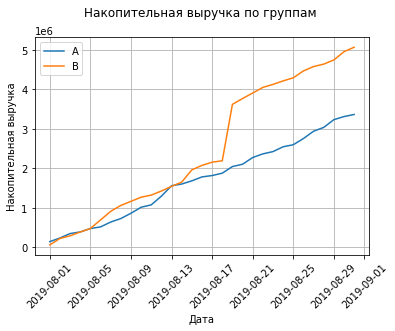

In [30]:
plt.plot(df['date'], df['revenueCummulativeA'], label='A')
plt.plot(df['date'], df['revenueCummulativeB'], label='B')
plt.xticks(rotation=45)
plt.grid(True) 
plt.xlabel("Дата")
plt.ylabel("Накопительная выручка")
plt.title("Накопительная выручка по группам \n")
plt.legend()
plt.show()


**Итог по графику:**
1. Группа имеет более высокиую выручку на протяжении всего перода наблюдений.
2. Результаты группы B резко возрастают около  18 августа и преимущество над группой А стабилизируется. Резкий скачеок 18 августа нуждается вдополнительном анализе, он может быть связан с аномально высоким количеством заказов  или их аномально высокой суммой.

### Постройте график кумулятивного среднего чека по группам**

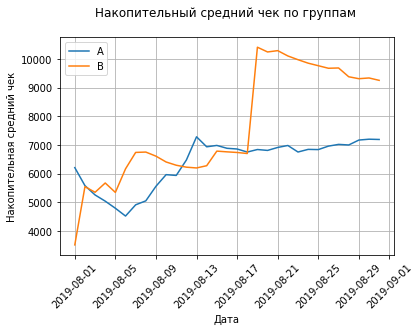

In [31]:
plt.plot(df['date'], (df['revenueCummulativeA']/df['ordersCummulativeA']), label ='A')
plt.plot(df['date'], (df['revenueCummulativeB']/df['ordersCummulativeB']), label ='B')
plt.xticks(rotation=45)
plt.grid(True) 
plt.xlabel("Дата")
plt.ylabel("Накопительная средний чек")
plt.title("Накопительный средний чек по группам \n")
plt.legend()
plt.show()

**Итог по графику**

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A**

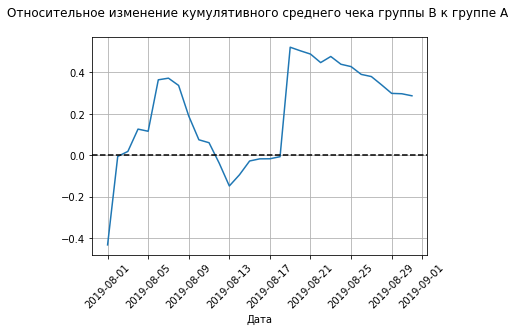

In [32]:
plt.plot(df['date'], (df['revenueCummulativeB']/df['ordersCummulativeB']/(df['revenueCummulativeA']/df['ordersCummulativeA']) - 1))
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.grid(True) 
plt.xlabel("Дата")
plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A \n")
plt.show()

**Итог по графику:**
1. В целом группа В имеет значительно больший средний чек, чем группа А.
2. Однако на второй неделе теста мы видим что группа А превосходит В в размере среднего чека.
3. На третьей неделе средний чек группы В становится существенно больше, чем у группы А и стабилизируется на уровне +25% к концу теста.
4. Необходимо очистить данные от выбросов и  оценить динамику показателей, чтобы получить более объективную картину.

### Построим график кумулятивного среднего количества заказов на посетителя по группам**

In [33]:
print(df.columns.to_list())

['date', 'ordersPerDateA', 'revenuePerDateA', 'ordersPerDateB', 'revenuePerDateB', 'ordersCummulativeA', 'revenueCummulativeA', 'ordersCummulativeB', 'revenueCummulativeB', 'visitorsPerDateA', 'visitorsPerDateB', 'visitorsCummulativeA', 'visitorsCummulativeB']


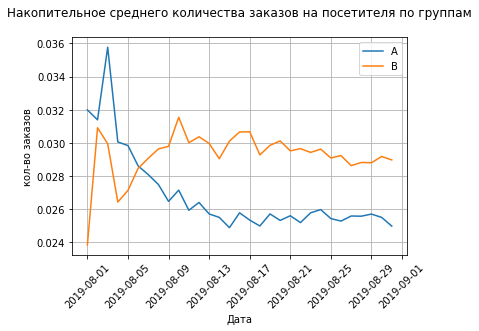

In [34]:
plt.plot(df['date'], df['ordersCummulativeA']/df['visitorsCummulativeA'], label='A')
plt.plot(df['date'], df['ordersCummulativeB']/df['visitorsCummulativeB'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True) 
plt.xlabel("Дата")
plt.ylabel("кол-во заказов")
plt.title("Накопительное среднего количества заказов на посетителя по группам\n")
# plt.axis(["2019-08-01", '2019-08-31', 0, 0.015]) 

plt.show()

**Итог:**
1. Графики кумулятивного среднего количества заказов обеих групп имеют значительные флуктуации на первой неделе теста, однако к 6 августа группа В начинает демонстрировать большее среднее количество заказов на пользователя
2. Показатели в обеих группах стабилизируются с 8 августа.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

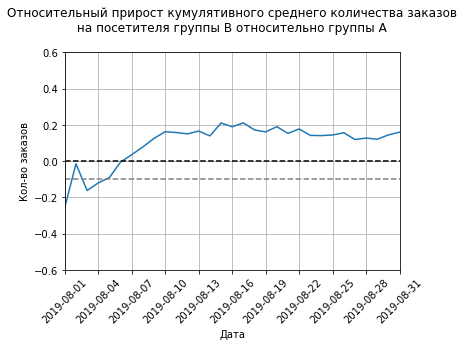

In [35]:
plt.plot(df['date']
             ,(df['ordersCummulativeB']/df['visitorsCummulativeB'])
             /(df['ordersCummulativeA']/df['visitorsCummulativeA']) - 1
             # , label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A"
        )
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Относительный прирост кумулятивного среднего количества заказов\n на посетителя группы B относительно группы A \n")
plt.xlabel("Дата")
plt.ylabel("Кол-во заказов")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

# Устанавливаем границы осей
plt.xlim(pd.Timestamp("2019-08-01"), pd.Timestamp("2019-08-31"))
plt.ylim(-0.6, 0.6)

# Форматирование дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Шаг в 3 дня

# plt.legend()
plt.show()

**Итог:**
1. В начале теста группа B проигрывала группе A, затем вырвалась вперёд и стабилизровалась и превышает показатели группы B примерно на 17%

### Построим точечный график количества заказов по пользователям**

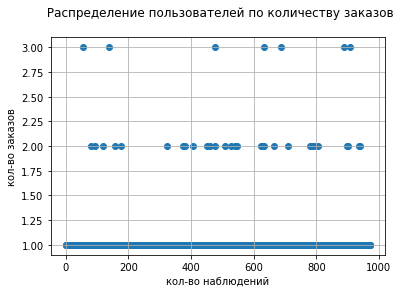

In [36]:
ordersByUsers =  orders.groupby('visitorId').agg(
    orders = ('transactionId', 'nunique')
    ).reset_index()

# ordersByUsers.sort_values('orders', ascending = False)
x_values=pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.grid(True) 
plt.xlabel("кол-во наблюдений")
plt.ylabel("кол-во заказов")
plt.title(" Распределение пользователей по количеству заказов\n")
plt.show()

**Итог по графику:**
- большинство пользователей совершило 1-2 заказа за период тестиирования
- пользователей, совершивших более 3 закзов значительно меньше, данные по ним выглядят как выбросы. Проведем дополнительный анализ, чтобы определиться стоит ли их исключать из выборки.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя**

In [37]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


**Итог:**
- Чтобы отсечь пользователей совершающих нетипично большое количество закаказов и способных повлиять на результаты исследование, будем считать выбросами более 2 заказов на человека Это составит менее 1% данных.

### Построим точечный график стоимостей заказов**

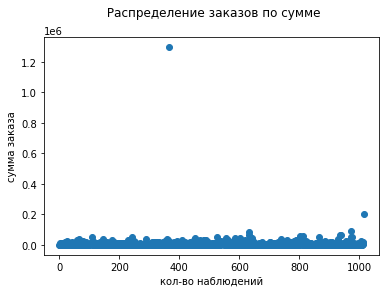

In [38]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.xlabel("кол-во наблюдений")
plt.ylabel("сумма заказа")
plt.title(" Распределение заказов по сумме\n")
plt.show()

In [39]:
# выведем заказы с аномально высокой суммой
orders.loc[orders['revenue']>150000]

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


**Итог:**
- вы выборке притствуют как минимум 2 заказа с аномально высокими суммами  - 1,2 и 0,2 млн руб. Оба они сделаны пользователями группы B. Оба они имеют скорее ситуативный характер и не связаны с тестируемым параметром. Либо являются ошибкой. Т.е. это - выбросы, которые должны быть удалены из выборки.
Проведем дополнителльный анализ, чтобы определить границу отсечения выбросов.

### Посчитаем 95-й и 99-й перцентили стоимости заказов**

In [40]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


**Итог:**
- резкий всплеск суммы среднего чека в группе B на третьей неделе теста связан с заказами с аномально высокой суммой
- стоимость  99% заказов  не превышает 53904 руб. Удалим из выборки заказы выше этой суммы

## Рассчитаем статистическую значимости для тестируемых гипотез

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным**

- Н0: Значимыйх различий в среднем количестве заказов на посетителя между группами  А и В нет
- Н1: Пользователи группы B в среднем делают больше заказов, чем пользователи группы А
- Уровень статистической значимости - 5%

In [41]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 
ordersByUsersB.head(2)

,userId,orders
0,5114589,1
1,6958315,1


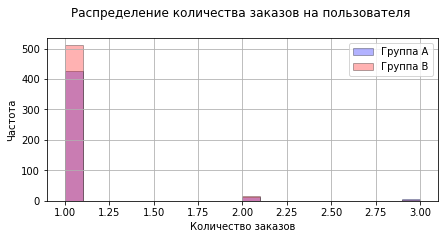

In [42]:
# Оценим распределение данных в выборках 
plt.figure(figsize=(7, 3))  # Задаем размер графика

plt.hist(ordersByUsersA['orders'], bins=20, alpha=0.3, label="Группа A", color="blue", edgecolor="black")
plt.hist(ordersByUsersB['orders'], bins=20, alpha=0.3, label="Группа B", color="red", edgecolor="black")

plt.xlabel("Количество заказов")
plt.ylabel("Частота")
plt.title("Распределение количества заказов на пользователя \n")
plt.legend()
plt.grid(True)  # Добавляем сетку для удобства

plt.show()

Т.к. распределение параметра не является нормальным, применим к данным критерий Манна-Уитни

In [43]:
# Подготовим выборки к проверке критерием Манна-Уитни.
# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. 

sampleA = pd.concat([ordersByUsersA['orders']
                     ,pd.Series(0, index=np.arange(df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders']
                     ,pd.Series(0, index=np.arange(df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

sampleA.head(100)

0     1
1     1
2     1
3     1
4     1
     ..
95    1
96    1
97    1
98    1
99    1
Name: orders, Length: 100, dtype: int64

In [44]:
print("Результаты теста на неочищенных данных:")
print(f'p-value: {"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])}')
print(f'Относительное изменение среднего числа заказов: {"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)}')

Результаты теста на неочищенных данных:
p-value: 0.011
Относительное изменение среднего числа заказов: 0.160


**Итог:**
- p-value < уровня стат. значимости - отвергаем гипотезу о равенстве среднего количества заказов среди пользователей обеих групп
- Среднее количество заказов на одного пользователя в группе В превосходит этот показатель в группе А на 16%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
- Н0: между средним чеком в группе А и средним чеком в группе В нет статистически значимой разницы
- Н1: средний чек в группе В больше чем в группе А
- Уровень статистической значисмости - 5%

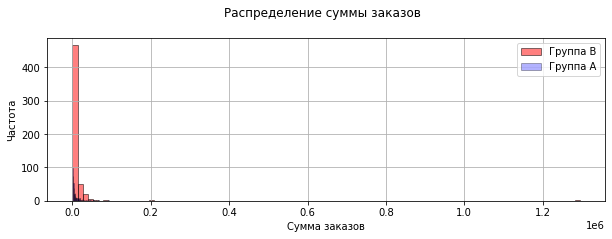

In [45]:
# Оценим распределение данных в выборках 
plt.figure(figsize=(10, 3))  # Задаем размер графика
plt.hist(orders[orders['group']=='B']['revenue'], bins=100, alpha=0.5, label="Группа B", color="red", edgecolor="black")
plt.hist(orders[orders['group']=='A']['revenue'], bins=100, alpha=0.3, label="Группа A", color="blue", edgecolor="black")

plt.xlabel("Сумма заказов")
plt.ylabel("Частота")
plt.title("Распределение суммы заказов  \n")
plt.legend()
plt.grid(True)  # Добавляем сетку для удобства

plt.show()

In [46]:
print("Результаты теста на неочищенных данных:")
print(f"p-value: {'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])}")
print(f"Относительное изменение среднего чека В к А: {'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)}")

Результаты теста на неочищенных данных:
p-value: 0.829
Относительное изменение среднего чека В к А: 0.287


**Итог:**

- Средний чек в группе В превосходит этот  показатель в группе А на 28.7 %. 
- При этом наблюдаемая разница в средних чеках групп А и В не являеся статистически значимой: p-value > уровня стат. значимости - нет оснований отвергать гипотезу об отсутствии статистически значимых различий в средних чеках обеих групп.
- Проверим выводы на данных очищенных от выбросов. 

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [47]:
# объединим пользователей с аномально высоким числом или суммой заказа в один список
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] >= 3]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
16


In [48]:
# Уберем из группы А аномальных пользователей
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            ~(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Уберем из группы B аномальных пользователей
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [49]:
print()
print("Результаты теста на неочищенных данных:")
print(f'p-value: {"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])}')
print(f'Относительное изменение среднего числа заказов в группе В к А: {"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)}')
print()
print("Результаты теста на очищенных данных:")
print(f'p-value: {"{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])}')
print(f'Относительное изменение среднего числа заказов в группе В к А: {"{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1)}')


Результаты теста на неочищенных данных:
p-value: 0.011
Относительное изменение среднего числа заказов в группе В к А: 0.160

Результаты теста на очищенных данных:
p-value: 0.007
Относительное изменение среднего числа заказов в группе В к А: 0.189


**Итог:**
- на очищенных данных выводы относительно изменения среднего чека кардинально не поменялись:
1.  p-value < уровня стат. значимости - отвергаем гипотезу о равенстве среднего количества заказов среди пользователей обеих групп
2. Среднее количество заказов на одного пользователя в группе В превосходит этот показатель в группе А на 18%


### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [50]:
 orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [51]:
# Вычисляем p_value
p_value = stats.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'],
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'],
)[1]

# Вычисляем относительное изменение среднего чека
prof = (
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'].mean()
    / orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'].mean()
    - 1
)

# Выводим результаты
print()
print("Результаты теста на неочищенных данных:")
print(f"p-value: {'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])}")
print(f"Относительное изменение среднего чека В к А: {'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)}")
print()
print("Результаты теста на очищенных данных:")
print(f"p-value: {p_value:.3f}")
print(f"Относительное изменение среднего чека В к А: {prof:3f}")



Результаты теста на неочищенных данных:
p-value: 0.829
Относительное изменение среднего чека В к А: 0.287

Результаты теста на очищенных данных:
p-value: 0.788
Относительное изменение среднего чека В к А: -0.032335


**Итог:**
- После анализа на очищенных данных выводы частично скорректировались:
1. Относительное изменение среднего чека в группе В к группе А составило -3%. 
2. Разница между полученными показателями не является статистически значимой, т.к. по результатм стат.теста нет оснований отвергать гипотезу об отсутствии значимых различий между показателями обеих групп.

## Итог:

1. Обнаружена статистически значимая разница между группами по показателю "Среднее количество заказов на пользователя". В группе В этот показатель выше, чем  в группе А примерно на 16%

2. Не обнаружено статистически значимой разницы между группами по показателю "Средний чек". Относительное изменение среднего чека в группеИ к Группе А  составляет -3%.

Скачок в показателях на графиках обусловлен выбросами в данных: несколькими заказами с аномально высокой суммой. Такие заказы, как правило, носят случайный характер и не связаны с тестируемыми изменениями.

**Вывод по результатам теста:**
- Фиксируем статистически значимое преимущество группы В по показателю "Среднее количество заказов на пользователя" (+16%) и останавливаем тест.

